In [51]:
# import packages
import os
import pickle
from tqdm import tqdm
import random
from tabulate import tabulate

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as t

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam
from torchvision import models
from torchvision.transforms.v2 import Resize, Compose, RandomHorizontalFlip, ColorJitter, RandomAffine, RandomErasing, ToTensor
from utils import get_img_pths, select_elements_with_spacing, preprocess_jpeg

fetch_img_paths = get_img_pths 

l = os.listdir
j = os.path.join

In [52]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True 

seed_everything(128)

In [53]:
TRAIN_IMG_PATH = 'C:\\first_workspace\\Data\\nBD'
TRAIN_DF_PATH = 'C:\\first_workspace\\Data\\data.csv'
input_img_group = 10

### sample

100%|██████████| 2110/2110 [00:01<00:00, 1516.19it/s]


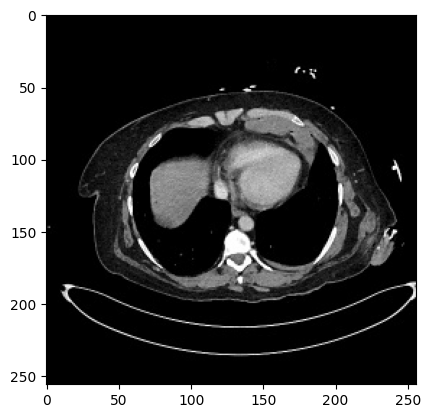

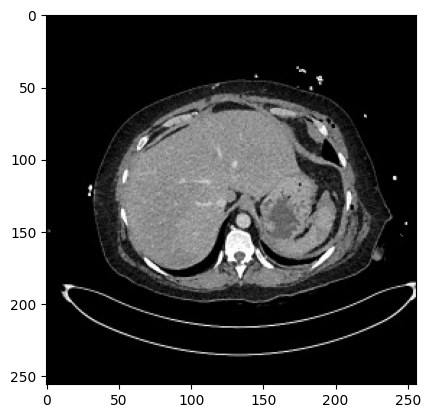

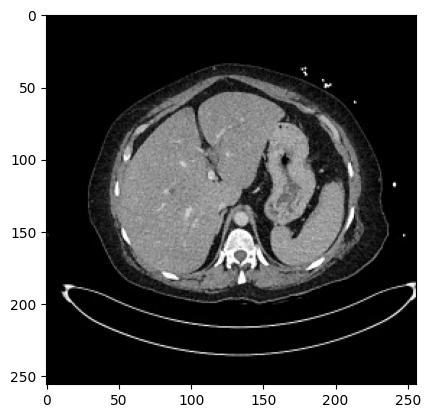

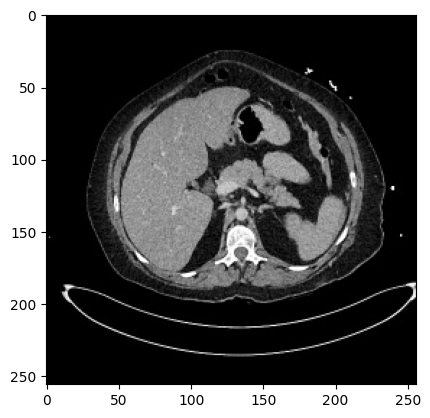

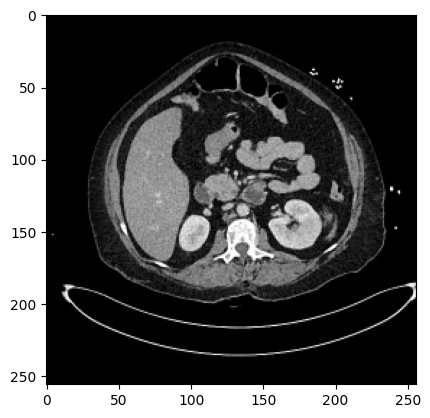

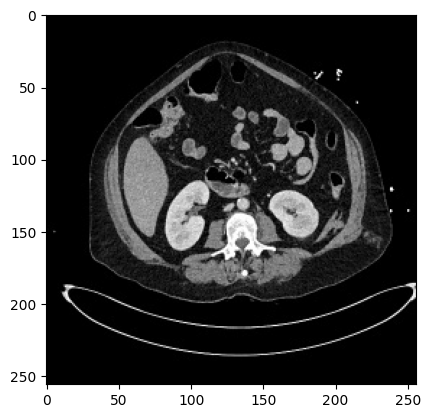

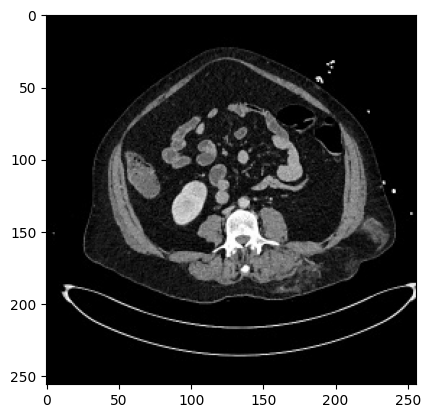

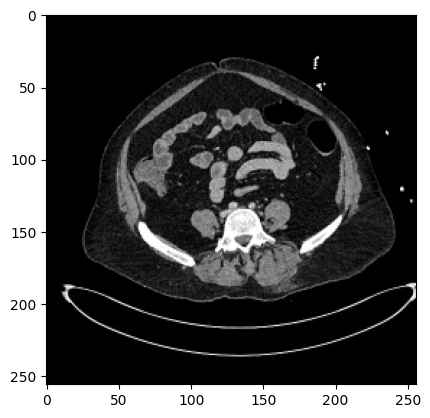

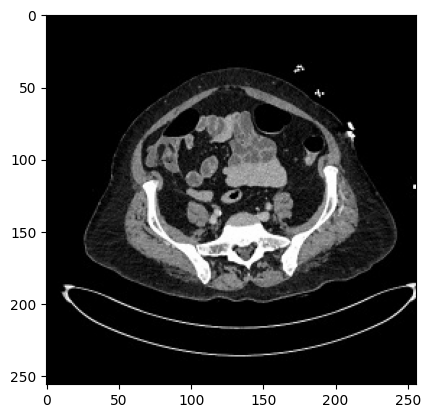

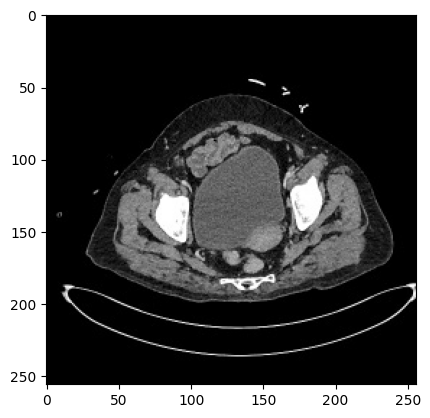

In [54]:
d_img_paths = fetch_img_paths(TRAIN_IMG_PATH)
d_imgs = select_elements_with_spacing(d_img_paths[0], input_img_group)
for i in d_imgs:
    img = cv2.imread(i)
    plt.imshow(img, cmap='gray')
    plt.show()

In [55]:
# dataset
class AbdominalData(Dataset):

    def __init__(self, df_path, current_fold, num_fold = 5):
        
        super().__init__()
        
        # collect all the image instance paths
        self.img_paths = fetch_img_paths(TRAIN_IMG_PATH)
                
        self.df = pd.read_csv(df_path)
        
        self.num_fold = num_fold
        self.current_fold = current_fold
        self.kf = KFold(n_splits=num_fold)
        
        self.transform = Compose([
#                             Resize((256, 256), antialias=True),
                            RandomHorizontalFlip(),  # Randomly flip images left-right
                            ColorJitter(brightness=0.2),  # Randomly adjust brightness
                            ColorJitter(contrast=0.2),  # Randomly adjust contrast
                            RandomAffine(degrees=0, shear=10),  # Apply shear transformation
                            RandomAffine(degrees=0, scale=(0.8, 1.2)),  # Apply zoom transformation
                            RandomErasing(p=0.2, scale=(0.02, 0.2)), # Coarse dropout
                            ToTensor(),
                        ])
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        
        # sample 4 image instances
        dicom_images = select_elements_with_spacing(self.img_paths[idx], input_img_group)
        patient_id = dicom_images[0].split('\\')[-3]
        images = []
        
        for d in dicom_images:
            image = preprocess_jpeg(d)
            images.append(image)
            
        images = np.stack(images)
        image = torch.tensor(images, dtype = torch.float).unsqueeze(dim = 1)
        
        image = self.transform(image).squeeze(dim = 1)
        
        label = self.df[self.df.patient_id == int(patient_id)].values[0][1:-1]
        
        # labels
        bowel = np.argmax(label[0:2], keepdims = True)
        extravasation = np.argmax(label[2:4], keepdims = True)
        kidney = np.argmax(label[4:7], keepdims = False)
        liver = np.argmax(label[7:10], keepdims = False)
        spleen = np.argmax(label[10:], keepdims = False)
        
        
        return {
            'image': image,
            'bowel': bowel,
            'extravasation': extravasation,
            'kidney': kidney,
            'liver': liver,
            'spleen': spleen,
            'patient': int(patient_id) #added
        }
    
    def get_splits(self):
        
        fold_data = list(self.kf.split(self.img_paths))
        train_indices, val_indices = fold_data[self.current_fold]

        train_data = self._get_subset(train_indices)
        val_data = self._get_subset(val_indices)
        
        return train_data, val_data

    def _get_subset(self, indices):
        return Subset(self, indices)

In [56]:
from sklearn.metrics import f1_score ,recall_score, precision_score


class MetricsCalculator:
    
    def __init__(self, mode = 'binary'):
        
        self.probabilities = []
        self.predictions = []
        self.targets = []
        
        self.mode = mode
    
    def update(self, logits, target):
        """
        Update the metrics calculator with predicted values and corresponding targets.
        
        Args:
            predicted (torch.Tensor): Predicted values.
            target (torch.Tensor): Ground truth targets.
        """
        if self.mode == 'binary':
            probabilities = torch.sigmoid(logits)
            predicted = (probabilities > 0.5)
        else:
            probabilities = F.softmax(logits, dim = 1)
            predicted = torch.argmax(probabilities, dim=1)
            
        self.probabilities.extend(probabilities.detach().cpu().numpy())
        self.predictions.extend(predicted.detach().cpu().numpy())
        self.targets.extend(target.detach().cpu().numpy())
    
    def reset(self):
        """Reset the stored predictions and targets."""
        
        self.probabilities = []
        self.predictions = []
        self.targets = []
    
    def compute_f1_score(self):
        return f1_score(self.targets, self.predictions, average='weighted') if self.mode == 'multi' else f1_score(self.targets, self.predictions)

    def compute_recall_score(self):
        return recall_score(self.targets, self.predictions, average='weighted') if self.mode == 'multi' else recall_score(self.targets, self.predictions)

    def compute_precision_score(self):
        return precision_score(self.targets, self.predictions, average='weighted') if self.mode == 'multi' else precision_score(self.targets, self.predictions)
    
    def compute_auc(self):
            return roc_auc_score(self.targets, self.probabilities, multi_class = 'ovo', labels=[0, 1, 2]) if self.mode == 'multi' else roc_auc_score(self.targets, self.probabilities)
    
    def compute_accuracy(self):
        return accuracy_score(self.targets, self.predictions)


In [57]:
# Model Architecure
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.input = nn.Conv2d(input_img_group, 3, kernel_size = 3)
        
        model = models.efficientnet_b0(weights = 'IMAGENET1K_V1')
        
        self.features = model.features
        self.avgpool = model.avgpool
        
        #heads
        self.bowel = nn.Linear(1280, 1) #1,0

        self.extravasation = nn.Linear(1280, 1) #1.0

        self.kidney = nn.Linear(1280, 3)

        self.liver = nn.Linear(1280,3) 

        self.spleen = nn.Linear(1280, 3)
    
    def forward(self, x):
        
        # extract features
        x = self.input(x)
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        # output logits
        bowel = self.bowel(x)
        extravsation = self.extravasation(x)
        kidney = self.kidney(x)
        liver = self.liver(x)
        spleen = self.spleen(x)
        
        return bowel, extravsation, kidney, liver, spleen

In [58]:
model = CNNModel().to('cuda')

In [59]:
BATCH_SIZE = 10
NUM_EPOCHS = 12 #or 10
LR = 1e-4

In [60]:
train_data_0, val_data_0 = AbdominalData(TRAIN_DF_PATH, current_fold=0).get_splits()
train_data_1, val_data_1 = AbdominalData(TRAIN_DF_PATH, current_fold=1).get_splits()
train_data_2, val_data_2 = AbdominalData(TRAIN_DF_PATH, current_fold=2).get_splits()
train_data_3, val_data_3 = AbdominalData(TRAIN_DF_PATH, current_fold=3).get_splits()
train_data_4, val_data_4 = AbdominalData(TRAIN_DF_PATH, current_fold=4).get_splits()

train_dataloader_0 = DataLoader(train_data_0,batch_size = BATCH_SIZE, shuffle = True)
val_dataloader_0 = DataLoader(val_data_0,batch_size = BATCH_SIZE, shuffle = False)
train_dataloader_1 = DataLoader(train_data_1,batch_size = BATCH_SIZE, shuffle = True)
val_dataloader_1 = DataLoader(val_data_1,batch_size = BATCH_SIZE, shuffle = False)
train_dataloader_2 = DataLoader(train_data_2,batch_size = BATCH_SIZE, shuffle = True)
val_dataloader_2 = DataLoader(val_data_2,batch_size = BATCH_SIZE, shuffle = False)
train_dataloader_3 = DataLoader(train_data_3,batch_size = BATCH_SIZE, shuffle = True)
val_dataloader_3 = DataLoader(val_data_3,batch_size = BATCH_SIZE, shuffle = False)
train_dataloader_4 = DataLoader(train_data_4,batch_size = BATCH_SIZE, shuffle = True)
val_dataloader_4 = DataLoader(val_data_4,batch_size = BATCH_SIZE, shuffle = False)

100%|██████████| 2110/2110 [00:01<00:00, 1505.93it/s]
c:\first_workspace\copied_env\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
100%|██████████| 2110/2110 [00:01<00:00, 1473.96it/s]
c:\first_workspace\copied_env\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
100%|██████████| 2110/2110 [00:01<00:00, 1489.78it/s]
c:\first_workspace\copied_env\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torc

debug = AbdominalData(TRAIN_DF_PATH, current_fold=0)

for dic in debug:
    print(dic['image'].shape)

In [61]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
bce_b = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([4.0]).to('cuda'))
bce_e = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([6.0]).to('cuda'))
cce = nn.CrossEntropyLoss(label_smoothing = 0.05, weight = torch.tensor([2.0, 3.0, 5.0]).to('cuda'))
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

c:\first_workspace\copied_env\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [62]:
# initialize metrics objects
train_acc_bowel = MetricsCalculator('binary')
train_acc_extravasation = MetricsCalculator('binary')
train_acc_liver = MetricsCalculator('multi')
train_acc_kidney = MetricsCalculator('multi')
train_acc_spleen = MetricsCalculator('multi')

val_acc_bowel = MetricsCalculator('binary')
val_acc_extravasation = MetricsCalculator('binary')
val_acc_liver = MetricsCalculator('multi')
val_acc_kidney = MetricsCalculator('multi')
val_acc_spleen = MetricsCalculator('multi')

In [63]:
AccTrain_bowel = []
AccTrain_extra = []
AccTrain_liver = []
AccTrain_kidney = []
AccTrain_spleen = []


f1Train_bowel = []
f1Train_extra = []
f1Train_liver = []
f1Train_kidney = []
f1Train_spleen = []

aucTrain_bowel = []
aucTrain_extra = []
aucTrain_liver = []
aucTrain_kidney = []
aucTrain_spleen = []


precTrain_bowel = []
precTrain_extra = []
precTrain_liver = []
precTrain_kidney = []
precTrain_spleen = []


recTrain_bowel = []
recTrain_extra = []
recTrain_liver = []
recTrain_kidney = []
recTrain_spleen = []

In [64]:
AccTest_bowel = []
AccTest_extra = []
AccTest_liver = []
AccTest_kidney = []
AccTest_spleen = []


f1Test_bowel = []
f1Test_extra = []
f1Test_liver = []
f1Test_kidney = []
f1Test_spleen = []

aucTest_bowel = []
aucTest_extra = []
aucTest_liver = []
aucTest_kidney = []
aucTest_spleen = []


precTest_bowel = []
precTest_extra = []
precTest_liver = []
precTest_kidney = []
precTest_spleen = []


recTest_bowel = []
recTest_extra = []
recTest_liver = []
recTest_kidney = []
recTest_spleen = []

In [65]:

prev_val_best_loss = float('inf')

dataloaders = [(train_dataloader_0, val_dataloader_0),
               (train_dataloader_1, val_dataloader_1),
               (train_dataloader_2, val_dataloader_2), 
               (train_dataloader_3, val_dataloader_3)] 



for epoch in range(NUM_EPOCHS):
    
    # training
    model.train()
    
    train_loss = 0.0
    val_loss = 0.0
    
    print(f'Epoch: [{epoch+1}/{NUM_EPOCHS}]')
    
    train_dataloader, val_dataloader = dataloaders[epoch%4] #5 for 5 fold
    
    print(f'Fold: {epoch%4}') #5 for 5 fold
    
    for batch_idx, batch_data in enumerate(tqdm(train_dataloader)):
        
        inputs = batch_data['image'].to('cuda')
        bowel = batch_data['bowel'].to('cuda')
        extravasation = batch_data['extravasation'].to('cuda')
        liver = batch_data['liver'].to('cuda')
        kidney = batch_data['kidney'].to('cuda')
        spleen = batch_data['spleen'].to('cuda')
        
        optimizer.zero_grad()
        b, e, k, l, s = model(inputs)
        b_loss = bce_b(b, bowel.float())
        e_loss = bce_e(e, extravasation.float())
        l_loss = cce(l, liver)
        k_loss = cce(k, kidney)
        s_loss = cce(s, spleen)
        
        total_loss = b_loss + e_loss + l_loss + k_loss + s_loss
        total_loss.backward()
        
        optimizer.step()
        
        # calculate training metrics
        train_loss += total_loss.item()
        train_acc_bowel.update(b, bowel)
        train_acc_extravasation.update(e, extravasation)
        train_acc_liver.update(l, liver)
        train_acc_kidney.update(k, kidney)
        train_acc_spleen.update(s, spleen)


    
    train_loss = train_loss/(batch_idx+1)
    
    # validation
    model.eval()
    running_loss = 0.0
    
    for batch_idx, batch_data in enumerate(tqdm(val_dataloader)):
                                                
        inputs = batch_data['image'].to('cuda')
        bowel = batch_data['bowel'].to('cuda')
        extravasation = batch_data['extravasation'].to('cuda')
        liver = batch_data['liver'].to('cuda')
        kidney = batch_data['kidney'].to('cuda')
        spleen = batch_data['spleen'].to('cuda')

        
        b, e, k, l, s = model(inputs)
        b_loss = bce_b(b, bowel.float())
        e_loss = bce_e(e, extravasation.float())
        l_loss = cce(l, liver)
        k_loss = cce(k, kidney)
        s_loss = cce(s, spleen)
        
        total_loss = b_loss + e_loss + l_loss + k_loss + s_loss
        
        # calculate validation metrics
        val_loss += total_loss.item()
        val_acc_bowel.update(b, bowel)
        val_acc_extravasation.update(e, extravasation)
        val_acc_liver.update(l, liver)
        val_acc_kidney.update(k, kidney)
        val_acc_spleen.update(s, spleen)
    
    
    val_loss = val_loss/(batch_idx+1)
    scheduler.step(val_loss)
    
    if val_loss < prev_val_best_loss:
        prev_val_best_loss = val_loss
        print("Validation Loss improved, Saving Model...")
        torch.save(model.state_dict(), f'efficientnet_b0_{val_loss:.3f}.pth')

    
    #collect accuracies
    AccTrain_bowel.append(train_acc_bowel.compute_accuracy())
    AccTrain_extra.append(train_acc_extravasation.compute_accuracy())
    AccTrain_liver.append(train_acc_liver.compute_accuracy())
    AccTrain_kidney.append(train_acc_kidney.compute_accuracy())
    AccTrain_spleen.append(train_acc_spleen.compute_accuracy())

    #collect f1_score:
    f1Train_bowel.append(train_acc_bowel.compute_f1_score())
    f1Train_extra.append(train_acc_extravasation.compute_f1_score())
    f1Train_liver.append(train_acc_liver.compute_f1_score())
    f1Train_kidney.append(train_acc_kidney.compute_f1_score())
    f1Train_spleen.append(train_acc_spleen.compute_f1_score())

    #collect auc score:
    aucTrain_bowel.append(train_acc_bowel.compute_auc())
    aucTrain_extra.append(train_acc_extravasation.compute_auc())
    aucTrain_liver.append(train_acc_liver.compute_auc())
    aucTrain_kidney.append(train_acc_kidney.compute_auc())
    aucTrain_spleen.append(train_acc_spleen.compute_auc())

    #collect precisison score
    precTrain_bowel.append(train_acc_bowel.compute_precision_score())
    precTrain_extra.append(train_acc_extravasation.compute_precision_score())
    precTrain_liver.append(train_acc_liver.compute_precision_score())
    precTrain_kidney.append(train_acc_kidney.compute_precision_score())
    precTrain_spleen.append(train_acc_spleen.compute_precision_score())

    #collect recall score
    recTrain_bowel.append(train_acc_bowel.compute_recall_score())
    recTrain_extra.append(train_acc_extravasation.compute_recall_score())
    recTrain_liver.append(train_acc_liver.compute_recall_score())
    recTrain_kidney.append(train_acc_kidney.compute_recall_score())
    recTrain_spleen.append(train_acc_spleen.compute_recall_score())


    #-----------------------------------------------------
    #                       TEST
    # ----------------------------------------------------
    AccTest_bowel.append(val_acc_bowel.compute_accuracy())
    AccTest_extra.append(val_acc_extravasation.compute_accuracy())
    AccTest_liver.append(val_acc_liver.compute_accuracy())
    AccTest_kidney.append(val_acc_kidney.compute_accuracy())
    AccTest_spleen.append(val_acc_spleen.compute_accuracy())

    #collect f1_score:
    f1Test_bowel.append(val_acc_bowel.compute_f1_score())
    f1Test_extra.append(val_acc_extravasation.compute_f1_score())
    f1Test_liver.append(val_acc_liver.compute_f1_score())
    f1Test_kidney.append(val_acc_kidney.compute_f1_score())
    f1Test_spleen.append(val_acc_spleen.compute_f1_score())

    #collect auc score:
    aucTest_bowel.append(val_acc_bowel.compute_auc())
    aucTest_extra.append(val_acc_extravasation.compute_auc())
    aucTest_liver.append(val_acc_liver.compute_auc())
    aucTest_kidney.append(val_acc_kidney.compute_auc())
    aucTest_spleen.append(val_acc_spleen.compute_auc())

    #collect precisison score
    precTest_bowel.append(val_acc_bowel.compute_precision_score())
    precTest_extra.append(val_acc_extravasation.compute_precision_score())
    precTest_liver.append(val_acc_liver.compute_precision_score())
    precTest_kidney.append(val_acc_kidney.compute_precision_score())
    precTest_spleen.append(val_acc_spleen.compute_precision_score())

    #collect recall score
    recTest_bowel.append(val_acc_bowel.compute_recall_score())
    recTest_extra.append(val_acc_extravasation.compute_recall_score())
    recTest_liver.append(val_acc_liver.compute_recall_score())
    recTest_kidney.append(val_acc_kidney.compute_recall_score())
    recTest_spleen.append(val_acc_spleen.compute_recall_score())
    
    # accuracy and auc data
    metrics_data = [
        ["Bowel", 
            train_acc_bowel.compute_accuracy(),
            val_acc_bowel.compute_accuracy(),
            train_acc_bowel.compute_f1_score(),
            val_acc_bowel.compute_f1_score(),
            train_acc_bowel.compute_precision_score(),
            val_acc_bowel.compute_precision_score(),
            train_acc_bowel.compute_recall_score(),
            val_acc_bowel.compute_recall_score(),
            train_acc_bowel.compute_auc(),
            val_acc_bowel.compute_auc()],
        ["Extravasation", 
            train_acc_extravasation.compute_accuracy(),
            val_acc_extravasation.compute_accuracy(),
            train_acc_extravasation.compute_f1_score(),
            val_acc_extravasation.compute_f1_score(),
            train_acc_extravasation.compute_precision_score(),
            val_acc_extravasation.compute_precision_score(),
            train_acc_extravasation.compute_recall_score(),
            val_acc_extravasation.compute_recall_score(),
            train_acc_extravasation.compute_auc(),
            val_acc_extravasation.compute_auc()],
        ["Liver", 
            train_acc_liver.compute_accuracy(),
            val_acc_liver.compute_accuracy(),
            train_acc_liver.compute_f1_score(),
            val_acc_liver.compute_f1_score(),
            train_acc_liver.compute_precision_score(),
            val_acc_liver.compute_precision_score(),
            train_acc_liver.compute_recall_score(),
            val_acc_liver.compute_recall_score(),
            train_acc_liver.compute_auc(),
            val_acc_liver.compute_auc()],
        ["Kidney", 
            train_acc_kidney.compute_accuracy(),
            val_acc_kidney.compute_accuracy(),
            train_acc_kidney.compute_f1_score(),
            val_acc_kidney.compute_f1_score(),
            train_acc_kidney.compute_precision_score(),
            val_acc_kidney.compute_precision_score(),
            train_acc_kidney.compute_recall_score(),
            val_acc_kidney.compute_recall_score(),
            train_acc_kidney.compute_auc(),
            val_acc_kidney.compute_auc()],
        ["Spleen", 
            train_acc_spleen.compute_accuracy(),
            val_acc_spleen.compute_accuracy(),
            train_acc_spleen.compute_f1_score(),
            val_acc_spleen.compute_f1_score(),
            train_acc_spleen.compute_precision_score(),
            val_acc_spleen.compute_precision_score(),
            train_acc_spleen.compute_recall_score(),
            val_acc_spleen.compute_recall_score(),
            train_acc_spleen.compute_auc(),
            val_acc_spleen.compute_auc()]
    ]

    
    # verbose
    print('')
    print(tabulate(metrics_data, headers=["", "Train Acc", "Val Acc", "Train AUC", "Val AUC", "Train F1", "Val F1", "Train Precision", "Val Precision", "Train Recall", "Val Recall"]))

    
    print(f'\nMean Train Loss: {train_loss:.3f}')
    print(f'Mean Val Loss: {val_loss:.3f}\n')
    
    #reset metrics
    train_acc_bowel.reset()
    train_acc_extravasation.reset()
    train_acc_liver.reset()
    train_acc_kidney.reset()
    train_acc_spleen.reset()
    val_acc_bowel.reset()
    val_acc_extravasation.reset()
    val_acc_liver.reset()
    val_acc_kidney.reset()
    val_acc_spleen.reset()


Epoch: [1/12]
Fold: 0


 11%|█         | 28/258 [00:19<02:39,  1.45it/s]


KeyboardInterrupt: 

In [ ]:
md = [
    [   "B",
        np.mean(AccTrain_bowel),
        np.mean(AccTest_bowel),

        np.mean(aucTrain_bowel),
        np.mean(aucTest_bowel),

        np.mean(f1Train_bowel),
        np.mean(f1Test_bowel),

        np.mean(recTrain_bowel),
        np.mean(recTest_bowel),

        np.mean(precTrain_bowel),
        np.mean(precTest_bowel),

        ],
    [   "E",
        np.mean(AccTrain_extra),
        np.mean(AccTest_extra),

        np.mean(aucTrain_extra),
        np.mean(aucTest_extra),

        np.mean(f1Train_extra),
        np.mean(f1Test_extra),

        np.mean(recTrain_extra),
        np.mean(recTest_extra),

        np.mean(precTrain_extra),
        np.mean(precTest_extra),

        ],
    [   "L",
        np.mean(AccTrain_liver),
        np.mean(AccTest_liver),

        np.mean(aucTrain_liver),
        np.mean(aucTest_liver),

        np.mean(f1Train_liver),
        np.mean(f1Test_liver),

        np.mean(recTrain_liver),
        np.mean(recTest_liver),

        np.mean(precTrain_liver),
        np.mean(precTest_liver),

        ],
    [   "K",
        np.mean(AccTrain_kidney),
        np.mean(AccTest_kidney),

        np.mean(aucTrain_kidney),
        np.mean(aucTest_kidney),

        np.mean(f1Train_kidney),
        np.mean(f1Test_kidney),

        np.mean(recTrain_kidney),
        np.mean(recTest_kidney),

        np.mean(precTrain_kidney),
        np.mean(precTest_kidney),

        ],
    [   "S",
        np.mean(AccTrain_spleen),
        np.mean(AccTest_spleen),

        np.mean(aucTrain_spleen),
        np.mean(aucTest_spleen),

        np.mean(f1Train_spleen),
        np.mean(f1Test_spleen),

        np.mean(recTrain_spleen),
        np.mean(recTest_spleen),

        np.mean(precTrain_spleen),
        np.mean(precTest_spleen),

        ],
]

In [ ]:
print(tabulate(md, headers=["", "Train Acc", "Val Acc", "Train AUC", "Val AUC", "Train F1", "Val F1", "Train recall", "Val recall", "Train precisison", "Val precision"]))


      Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1    Train recall    Val recall    Train precisison    Val precision
--  -----------  ---------  -----------  ---------  ----------  --------  --------------  ------------  ------------------  ---------------
B      0.982901   0.985654     0.881924   0.904925    0.329846  0.355465        0.282402      0.441761            0.487321         0.420805
E      0.924141   0.914183     0.852869   0.879283    0.403347  0.431159        0.519526      0.609487            0.341406         0.356454
L      0.907527   0.903325     0.774131   0.80631     0.873281  0.86945         0.907527      0.903325            0.866544         0.862769
K      0.941368   0.938605     0.746859   0.778276    0.917193  0.912403        0.941368      0.938605            0.914143         0.903891
S      0.906429   0.908495     0.752759   0.777458    0.870474  0.87378         0.906429      0.908495            0.861975         0.864107
